In [1]:
import numpy as np
import os
import re
import sys
import cv2
import glob
import json
import random

from PIL import Image
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras import Model
from tensorflow.keras.utils import normalize
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, concatenate
from tfdiffeq.models.dense_odenet import ODEBlock
from tfdiffeq.models.conv_odenet import Conv2dTime
from skimage.io import imread, imshow
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from scipy import linspace, polyval, polyfit, sqrt, stats, randn
from matplotlib.pyplot import plot, title, show, legend

In [52]:
import tensorflow as tf

from typing import Any
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, concatenate
from tfdiffeq.models.dense_odenet import ODEBlock
from tfdiffeq.models.conv_odenet import Conv2dTime

MAX_NUM_STEPS = 1000 # Maximum number of steps for ODE solver

def get_non_linearity(name: str)->tf.keras.layers.Layer:
    """Resolve non-linearity to layer

    Arguments:
        name {str} -- name of non-linearity/activation function

    Returns:
        tf.keras.layers.Layer -- target activation layer
    """
    if name == 'relu':
        return tf.keras.layers.ReLU()
    elif name == 'softplus':
        return tf.keras.layers.Activation('softplus')
    elif name == 'lrelu':
        return tf.keras.layers.LeakyReLU(alpha=0.2)
    elif name == 'swish':
        return tf.keras.layers.Activation('swish')
    else:
        return tf.keras.layers.Activation(name)    

class Conv2dODEFunc(Model):

    def __init__(self, num_filters, augment_dim=0,
                 time_dependent=False, non_linearity='relu', **kwargs):
        """
        Convolutional block modeling the derivative of ODE system.
        # Arguments:
            num_filters : int
                Number of convolutional filters.
            augment_dim: int
                Number of augmentation channels to add. If 0 does not augment ODE.
            time_dependent : bool
                If True adds time as input, making ODE time dependent.
            non_linearity : string
                Activation function for activation layer. One of 'relu', 'softplus', 
                'lrelu' and 'swish'
        """
        dynamic = kwargs.pop('dynamic', True)
        super(Conv2dODEFunc, self).__init__(**kwargs, dynamic=dynamic)

        self.augment_dim = augment_dim
        self.time_dependent = time_dependent
        self.nfe = 0  # Number of function evaluations
        self.num_filters = num_filters
        self.input_dim = input

        if time_dependent:
            self.norm1 = BatchNormalization()
            self.conv1 = Conv2dTime(self.num_filters, kernel_size=3, stride=1, padding=0)
            self.norm2 = BatchNormalization()
            self.conv2 = Conv2dTime(self.num_filters, kernel_size=3, stride=1, padding=1)

        else:
            self.norm1 = BatchNormalization()
            self.conv1 = tf.keras.layers.Conv2D(self.num_filters, kernel_size=(3, 3), strides=(1, 1), padding='same')
            self.norm2 = BatchNormalization()
            self.conv2 = tf.keras.layers.Conv2D(self.num_filters, kernel_size=(3, 3), strides=(1, 1), padding='same')

        self.non_linearity = get_non_linearity(non_linearity)
            
    def build(self, input_shape):
        if input_shape:
            self.built = True
        

    @tf.function
    def call(self, t, x, training=None, **kwargs):
        """
        Parameters
        ----------
        t : Tensor
            Current time.
        x : Tensor
            Shape (batch_size, input_dim)
        """

        self.nfe += 1

        if self.time_dependent:
            out = self.norm1(x)
            out = self.conv1(t, x)
            out = self.non_linearity(out)
            out = self.norm2(out)
            out = self.conv2(t, out)
            out = self.non_linearity(out)
        else:
            out = self.norm1(x)
            out = self.conv1(out)
            out = self.non_linearity(out)
            out = self.norm2(out)
            out = self.conv2(out)
            out = self.non_linearity(out)

        return out
class UNode(Model):
    """Creates a U-Net with an ODEBlock and a convolutional ODEFunc, therefore a U-Node
    Parameters
    ----------
    num_filters : int
        Number of convolutional filters.
    input_dim : tuple of ints
        Tuple of (height, width, channels).
    output_dim : int
        Dimension of output after hidden layer. Should be 1 for regression or
        num_classes for classification.
    augment_dim: int
        Number of augmentation channels to add. If 0 does not augment ODE.
    time_dependent : bool
        If True adds time as input, making ODE time dependent.
    non_linearity : string
        Activation function for activation layer. One of 'relu', 'softplus', 
        'lrelu' and 'swish'
    tol : float
        Error tolerance.
    adjoint : bool
        If True calculates gradient with adjoint method, otherwise
        backpropagates directly through operations of ODE solver.
    solver: ODE solver. Defaults to DOPRI5.
    """
    def __init__(self, num_filters, input_dim, output_dim=1,
                 augment_dim=0, time_dependent=False, non_linearity='relu', out_strides=(1, 1),
                 tol=1e-3, adjoint=False, solver='dopri5', **kwargs):

        dynamic = kwargs.pop('dynamic', True)
        super(UNode, self).__init__(**kwargs, dynamic=dynamic)

        self.nf = num_filters
        self.augment_dim = augment_dim
        self.output_dim = output_dim
        self.time_dependent = time_dependent
        self.tol = tol
        self.solver = solver
        self.output_strides = out_strides
        self.input_dim = input_dim
        self.non_linearity = get_non_linearity(non_linearity)

        self.input_layer = Conv2D(filters=num_filters, kernel_size=(1, 1), padding='same', input_shape=input_dim)
        self.norm_range = tf.keras.layers.Lambda(lambda x: x / 255)

        #Contraction path
        ode_down1 = Conv2dODEFunc(num_filters=num_filters, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down1 = ODEBlock(odefunc=ode_down1, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down1_2 = Conv2D(filters=num_filters*2, kernel_size=(1, 1), padding='same')
        self.maxpool1 = MaxPooling2D(pool_size=(2, 2))

        ode_down2 = Conv2dODEFunc(num_filters=num_filters*2, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down2 = ODEBlock(odefunc=ode_down2, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down2_3 = Conv2D(filters=num_filters*4, kernel_size=(1, 1), padding='same')
        self.maxpool2 = MaxPooling2D(pool_size=(2, 2))

        ode_down3 = Conv2dODEFunc(num_filters=num_filters*4, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down3 = ODEBlock(odefunc=ode_down3, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down3_4 = Conv2D(filters=num_filters*8, kernel_size=(1, 1), padding='same')
        self.maxpool3 = MaxPooling2D(pool_size=(2, 2))

        ode_down4 = Conv2dODEFunc(num_filters=num_filters*8, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down4 = ODEBlock(odefunc=ode_down4, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down4_embed = Conv2D(filters=num_filters*16, kernel_size=(1, 1), padding='same')
        self.maxpool4 = MaxPooling2D(pool_size=(2, 2))

        ode_embed = Conv2dODEFunc(num_filters=num_filters*16, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_embending = ODEBlock(odefunc=ode_embed, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        #Expansive path
        self.transpose1 = Conv2DTranspose(filters=num_filters*8, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up_embed_1 = Conv2D(filters=num_filters*8, kernel_size=(1, 1), padding='same')
        ode_up1 = Conv2dODEFunc(num_filters=num_filters*8, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up1 = ODEBlock(odefunc=ode_up1, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.transpose2 = Conv2DTranspose(filters=num_filters*4, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up1_2 = Conv2D(filters=num_filters*4, kernel_size=(1, 1), padding='same')
        ode_up2 = Conv2dODEFunc(num_filters=num_filters*4, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up2 = ODEBlock(odefunc=ode_up2, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.transpose3 = Conv2DTranspose(filters=num_filters*2, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up2_3 = Conv2D(filters=num_filters*2, kernel_size=(1, 1), padding='same')
        ode_up3 = Conv2dODEFunc(num_filters=num_filters*2, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up3 = ODEBlock(odefunc=ode_up3, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.transpose4 = Conv2DTranspose(filters=num_filters, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up3_4 = Conv2D(filters=num_filters, kernel_size=(1, 1), padding='same')
        ode_up4 = Conv2dODEFunc(num_filters=num_filters, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up4 = ODEBlock(odefunc=ode_up4, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.classifier = Conv2D(filters=output_dim, kernel_size=(1, 1), activation='softmax')


    def call(self, inputs, return_features: bool=False):
        
        norm_inputs = self.norm_range(inputs)
        inps = self.input_layer(norm_inputs)
        x_cast = tf.cast(inps, dtype=tf.float64)
        
        # Contraction path
        features1 = self.odeblock_down1(x_cast)
        x = self.non_linearity(self.conv_down1_2(features1))
        x = self.maxpool1(x)
        #x = Dropout(0.1)(x)

        features2 = self.odeblock_down2(x)
        x = self.non_linearity(self.conv_down2_3(features2))
        x = self.maxpool2(x)
        #x = Dropout(0.1)(x)

        features3 = self.odeblock_down3(x)
        x = self.non_linearity(self.conv_down3_4(features3))
        x = self.maxpool3(x)
        #x = Dropout(0.2)(x)

        features4 = self.odeblock_down4(x)
        x = self.non_linearity(self.conv_down4_embed(features4))
        x = self.maxpool4(x)
        #x = Dropout(0.2)(x)

        x = self.odeblock_embending(x)

        #Expansive path
        x = self.transpose1(x)
        x = concatenate([x, features4])
        x = self.non_linearity(self.conv_up_embed_1(x))
        x = self.odeblock_up1(x)

        x = self.transpose2(x)
        x = concatenate([x, features3])
        x = self.non_linearity(self.conv_up1_2(x))
        x = self.odeblock_up2(x)

        x = self.transpose3(x)
        x = concatenate([x, features2])
        x = self.non_linearity(self.conv_up2_3(x))
        x = self.odeblock_up3(x)

        x = self.transpose4(x)
        x = concatenate([x, features1])
        x = self.non_linearity(self.conv_up3_4(x))
        x = self.odeblock_up4(x)

        pred = self.classifier(x)

        if return_features:
            return features4, pred
        else:
            return pred

# Get U-Node model
def get_unode_model(input_dim: tuple, filters: int=4, output_dim=6, non_linearity: str='lrelu', solver: str='adams') -> UNode:
    """Get an instance of UNode model

    Arguments:
        input_dim {tuple} -- shape of input in the form (height, width, channels) e.g. (256, 256, 3)

    Keyword Arguments:
        filters {int} -- number of filters to apply in convolutions (default: {4})
        non_linearity {str} -- activation function (default: {'lrelu'})
        solver {str} -- ODE solver to be applied (default: {'adams'})

    Returns:
        UNode -- an instance of the UNode model class
    """
    return UNode(num_filters=filters, input_dim=input_dim, output_dim=output_dim, non_linearity=non_linearity, solver=solver)

In [3]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
NUM_IMAGES = 100
NUM_CLASSES = 6

TRAIN_PATH = 'multi_class/data/train_set/'
TEST_PATH = 'multi_class/data/test_set/'

In [4]:
## Load and build saved model
# Get instance of model
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
unode_model = get_unode_model(filters=8, input_dim=input_shape, output_dim=NUM_CLASSES, non_linearity='lrelu', solver='adams')
# Compile model
unode_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# initialize/build model by predicting on zeroes tensor
init_preds = unode_model.predict(np.zeros((1, 128, 128, 3)))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [5]:
unode_model.load_weights('u-node result/multi-class segmentation/128_x_128/final_run_1/saved_model/unode.tf')

In [6]:
open("dataset/Eval/test_label.json")
json_gt = [json.loads(line) for line in open("dataset/Eval/test_label.json")]

In [7]:
mask_names = glob.glob("dataset/new/test_set/instance_label/*.png")
test_masks=[]
mask_names.sort()
for mask in mask_names:
  mask = cv2.imread(mask,cv2.IMREAD_GRAYSCALE)
  test_masks.append(mask)
test_masks = np.array(test_masks)

In [8]:
image_path=["dataset/Eval/"+json_gt[i]['raw_file'] for i in range(0,len(json_gt))]
imshow(images)
plt.show()

NameError: name 'images' is not defined

(1, 128, 128, 6)


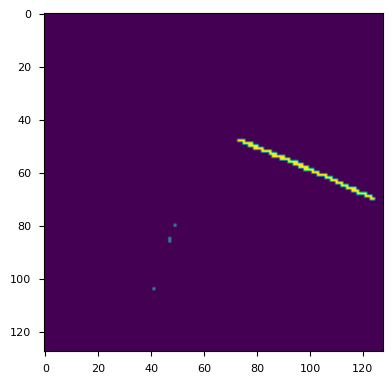

In [36]:
img = images.reshape(1,128,128,3)
prediction=(unode_model.predict(img))
print(prediction.shape)
plt.imshow(np.argmax(prediction, axis=3)[0,:,:])
plt.show()

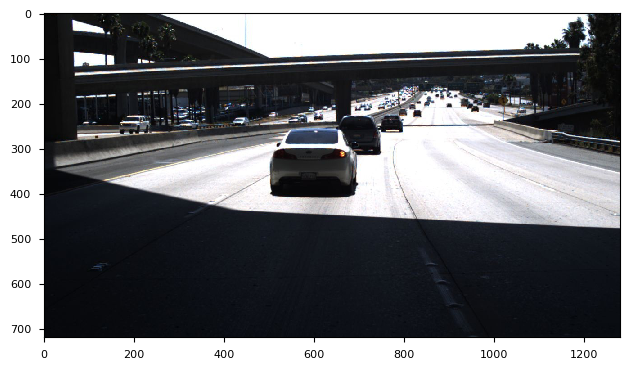

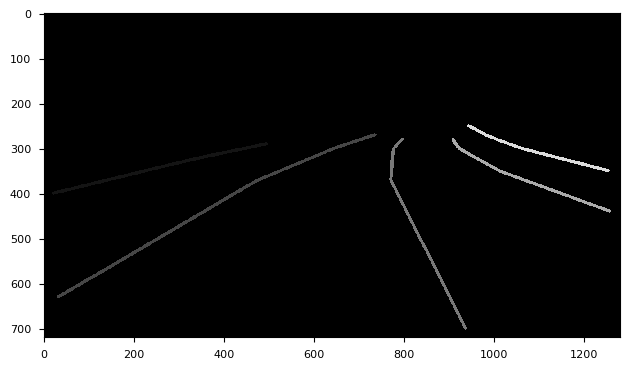

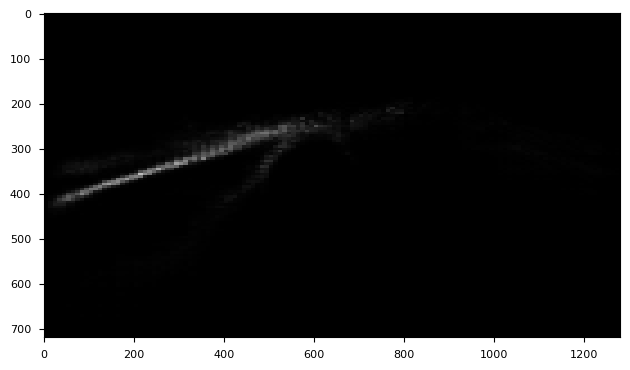

C:\Users\ocbie\anaconda3\envs\tensorflow-env\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


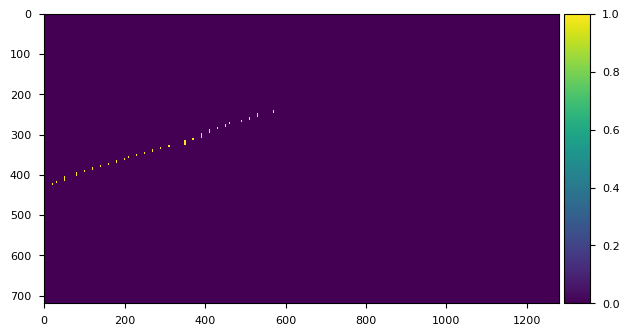

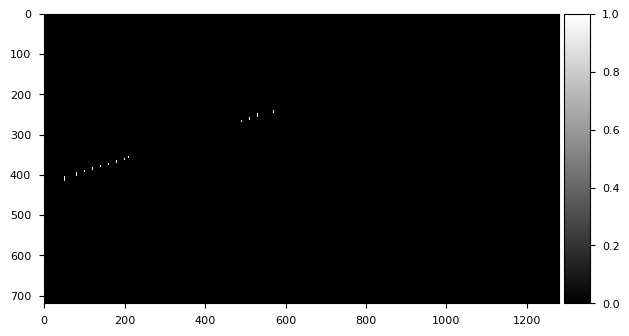

(11, 19)


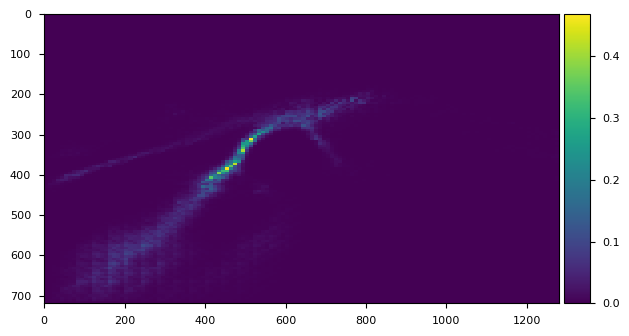

C:\Users\ocbie\anaconda3\envs\tensorflow-env\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


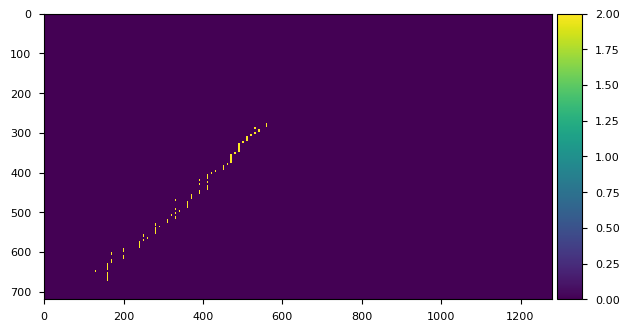

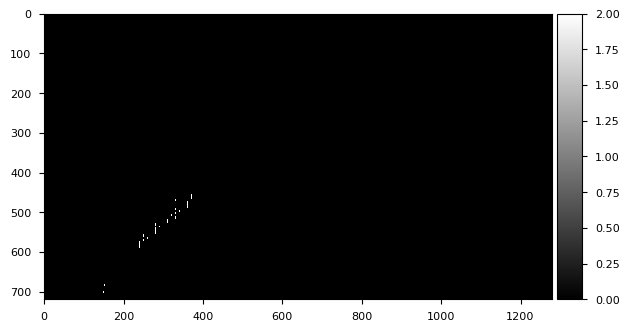

(11, 44)


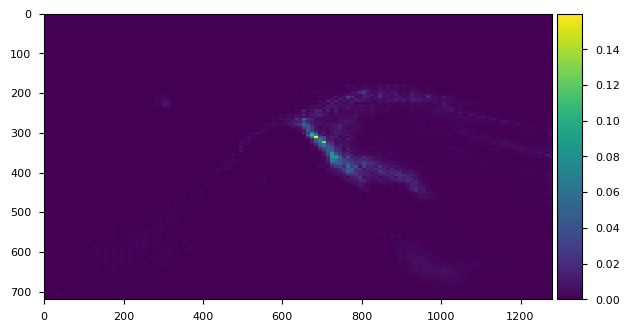

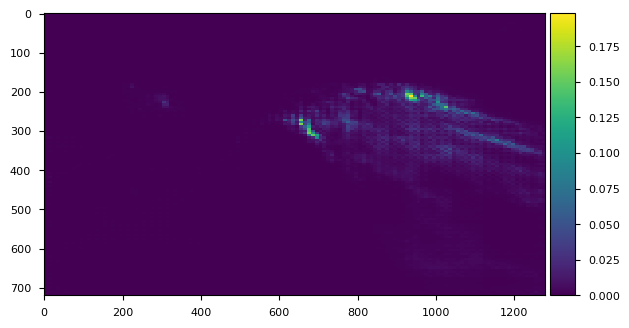

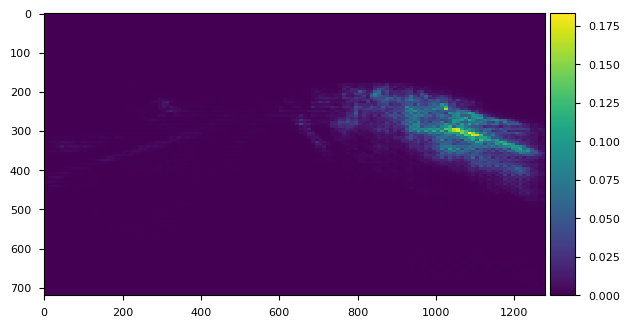

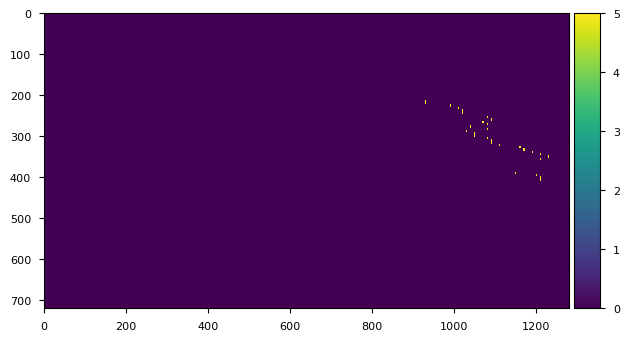

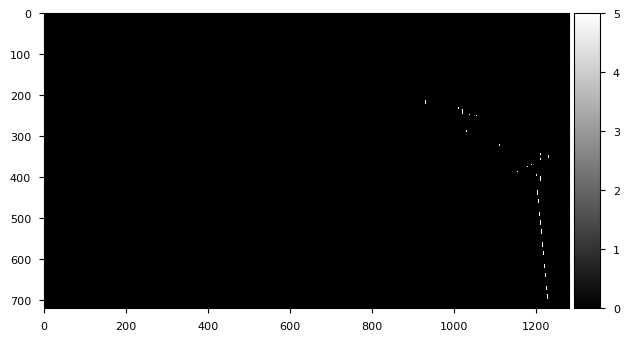

(8, 50)
0.26548672566371684


In [9]:
def isClosed(lane1,lane2,threshold):
    sum=0
    count=0
    for i in range(0,len(lane1)):
        if lane1[i]!=-2 and lane2[i]!=-2:
            sum=abs(lane1[i]-lane2[i])+sum
            count=count+1
    if count==0:
        return False
    elif sum/count>threshold:
        return False
    else:
        return True
def evaluate(lane,json,threshold):
    oldcor=0
    oldreq=0
    for i in range(0,len(json)):
        correct=0
        request=0
        for j in range(0,56):
            if lane[j]!=-2:
                request=request+1
                if abs(lane[j]-json[i][j])<threshold or ((lane[j]<threshold or lane[j]>1280-threshold) and json[i][j]==-2):
                    correct=correct+1
        if (oldreq==0) or (request>0 and correct/request>oldcor/oldreq):
            oldcor=correct
            oldreq=request
    return oldcor,oldreq
def near_smooth(coord2,coord1,coord3,tol_dis,tol_convex,skip_convex):
    y1=coord1[0]
    y2=coord2[0]
    y3=coord3[0]
    x1=coord1[1]
    x2=coord2[1]
    x3=coord3[1]
    distance=(y1-y2)**2+(x1-x2)**2
    if not skip_convex:
        m1=(x1-x2)/(y1-y2)
        m2=(x3-x2)/(y3-y2)
        convex= abs(m2-m1)/abs(y1-y3)
        #print(coord1,coord2,coord3)
        #print("m1=",m1,", m2=",m2,", y1=",y1,", y3=",y3,", convex=",convex)
        if np.amin(distance)>tol_dis and np.amin(convex)>tol_convex:
            return False
        else:
            return True
    elif distance>tol_dis:
        return False
    else:
        return True
def postprocessing(pic,tol_dis,tol_sharp):
    images=cv2.resize(imread(image_path[pic],0), dsize=(128, 128), interpolation=cv2.INTER_NEAREST)
    imshow(imread(image_path[pic],0))
    plt.show()
    imshow(test_masks[pic])
    plt.show()
    img = images.reshape(1,128,128,3)
    prediction=np.squeeze(unode_model.predict(img))
    prediction = cv2.resize(prediction, dsize=(1280, 720), interpolation=cv2.INTER_NEAREST)
    tol_dis=tol_dis
    tol_invtan=tol_sharp
    pp=np.array([])
    oldlane=np.array([])
    toreq=0
    tocorr=0
    for j in range(1,6):     
        new_pred=np.round(prediction[:,:,j],decimals=3)
        imshow(new_pred) 
        plt.show()
        group1=np.array([])
        group2=np.array([])
        predim1=np.zeros([720,1280])
        predim2=np.zeros([720,1280])
        predim3=np.zeros([720,1280])
        if np.average(new_pred[np.nonzero(new_pred)])<.01:
            continue
        threshold=np.average(new_pred[np.nonzero(new_pred)])+np.std(new_pred[np.nonzero(new_pred)])
        for y_coord in range(160,720):
            row=prediction[y_coord,:,j]
            prob=np.amax(row)       
            if prob>threshold:
                x_coord=np.amin(np.squeeze(np.where(row == prob)))
                predim1[y_coord,x_coord]=1
            else:
                continue
            group1add=group1.size==0 or (group1.size==2 and near_smooth(group1[0],[y_coord,x_coord],group1[-1],tol_dis,0,True)) or (group1.size>2 and near_smooth(group1[-1],[y_coord,x_coord],group1[-2],tol_dis,tol_invtan,False))
            group2add=group2.size==0 or (group2.size==2 and near_smooth(group2[0],[y_coord,x_coord],group2[-1],tol_dis,0,True)) or (group2.size>2 and near_smooth(group2[-1],[y_coord,x_coord],group2[-2],tol_dis,tol_invtan,False))
            if group1.size>0 and group2.size>0 and group1add and group2add:
                group1=np.reshape(np.append(group1,[y_coord,x_coord]),(-1,2))
                group2=np.reshape(np.append(group2,[y_coord,x_coord]),(-1,2))
            elif group1add:
                group1=np.reshape(np.append(group1,[y_coord,x_coord]),(-1,2))
            elif group1.size>0 and group2add:
                group2=np.reshape(np.append(group2,[y_coord,x_coord]),(-1,2))
            else:
                if group1.size<=group2.size:
                    group1=group2
                group2=np.array([[y_coord,x_coord]])
        if group1.size<=group2.size:
            group1=group2
        group1=group1.astype('int64')
        if group1.size<50 :
            continue
        for coord in group1:
            y=coord[0]
            x=coord[1]
            predim3[y,min(x+1,1280)]=j
            predim3[y,max(x-1,0)]=j
            predim3[y,x]=j
        imshow(predim3)   
        plt.show()
        if group1[-1,0]<715:
            t=group1[-52:-1,0]
            xn=group1[-52:-1,1]
            f = np.poly1d(np.polyfit(t, xn, 1))
            for i in range(round(group1[-1,0])+1,715):
                guess=round(f(i))
                if 0<guess<1280:
                     group1=np.reshape(np.append(group1,[i,guess],),(-1,2))
                else:
                    break
        high=group1[0,0]
        for i in range (high,min(710,group1[-1,0])-2):
            if group1[i-high,0]!=i:
                t=group1[i-high-1:i-high+1,0]
                xn=group1[i-high-1:i-high+1,1]
                f = np.poly1d(np.polyfit(t, xn, 1))
                guess=[[i,round(f(i))]for i in range(i,group1[i-high,0])]
                group1=np.insert(group1,i-high,guess,axis=0)
            predim2[group1[i-high,0],group1[i-high,1]]=j
            predim2=predim2.astype('uint8')
        lane=np.array([])
        for y in range(160,720,10):
            if y<group1[0][0]:
                lane=np.append(lane,[-2])
            elif y>group1[-1][0]:
                lane=np.append(lane,[-2])
            else:
                lane=np.append(lane,np.squeeze(group1[np.where(y==group1[:,0]),1]))
        if len(oldlane)>0 and isClosed(oldlane,lane,100):
            continue
        imshow(predim2,cmap="gray",interpolation="nearest")
        plt.show()
        oldlane=lane
        try:
            pp=np.stack([pp,lane])
        except:
            pp=np.append(pp,lane)
        print(evaluate(lane,json_gt[pic]['lanes'],50))
        correct,request=evaluate(lane,json_gt[pic]['lanes'],50)
        tocorr=tocorr+correct
        toreq=toreq+request
    pp=tocorr/toreq
    return pp
print(postprocessing(1166,5000,10**(-5)))

In [34]:
#This is the main module
def isClosed(lane1,lane2,threshold):
    sum=0
    count=0
    for i in range(0,len(lane1)):
        if lane1[i]!=-2 and lane2[i]!=-2:
            sum=abs(lane1[i]-lane2[i])+sum
            count=count+1
    if count==0:
        return False
    elif sum/count>threshold:
        return False
    else:
        return True
def evaluate(lane,json,threshold):
    oldcor=0
    oldreq=0
    for i in range(0,len(json)):
        correct=0
        request=0
        for j in range(0,56):
            if lane[j]!=-2:
                request=request+1
                if abs(lane[j]-json[i][j])<threshold or ((lane[j]<threshold or lane[j]>1280-threshold) and json[i][j]==-2):
                    correct=correct+1
        if (oldreq==0) or (request>0 and correct/request>oldcor/oldreq):
            oldcor=correct
            oldreq=request
    return oldcor,oldreq
def near_smooth(coord2,coord1,coord3,tol_dis,tol_convex,skip_convex):
    y1=coord1[0]
    y2=coord2[0]
    y3=coord3[0]
    x1=coord1[1]
    x2=coord2[1]
    x3=coord3[1]
    distance=(y1-y2)**2+(x1-x2)**2
    if not skip_convex:
        m1=(x1-x2)/(y1-y2)
        m2=(x3-x2)/(y3-y2)
        convex= abs(m2-m1)/abs(y1-y3)
        #print(coord1,coord2,coord3)
        #print("m1=",m1,", m2=",m2,", y1=",y1,", y3=",y3,", convex=",convex)
        if np.amin(distance)>tol_dis and np.amin(convex)>tol_convex:
            return False
        else:
            return True
    elif distance>tol_dis:
        return False
    else:
        return True
def postprocessing(pic,tol_dis,tol_sharp):
    images=cv2.resize(imread(image_path[pic],0), dsize=(128, 128), interpolation=cv2.INTER_NEAREST)
    img = images.reshape(1,128,128,3)
    prediction=np.squeeze(unode_model.predict(img))
    prediction = cv2.resize(prediction, dsize=(1280, 720), interpolation=cv2.INTER_NEAREST)
    tol_dis=tol_dis
    tol_invtan=tol_sharp
    oldlane=np.array([])
    toreq=np.zeros(4)
    tocorr=np.zeros(4)
    pp=np.array([])
    tocorrneg=np.zeros(4)
    toreqneg=np.zeros(4)
    for j in range(1,6):
        new_pred=np.round(prediction[:,:,j],decimals=3)
        group1=np.array([])
        group2=np.array([])
        predim1=np.zeros([720,1280])
        predim2=np.zeros([720,1280])
        if np.average(new_pred[np.nonzero(new_pred)])<.01:
            continue
        threshold=np.average(new_pred[np.nonzero(new_pred)])+np.std(new_pred[np.nonzero(new_pred)])
        for y_coord in range(160,720):
            row=prediction[y_coord,:,j]
            prob=np.amax(row)       
            if prob>threshold:
                x_coord=np.amin(np.squeeze(np.where(row == prob)))
                predim1[y_coord,x_coord]=1
            else:
                continue
            group1add=group1.size==0 or (group1.size==2 and near_smooth(group1[0],[y_coord,x_coord],group1[-1],tol_dis,0,True)) or (group1.size>2 and near_smooth(group1[-1],[y_coord,x_coord],group1[-2],tol_dis,tol_invtan,False))
            group2add=group2.size==0 or (group2.size==2 and near_smooth(group2[0],[y_coord,x_coord],group2[-1],tol_dis,0,True)) or (group2.size>2 and near_smooth(group2[-1],[y_coord,x_coord],group2[-2],tol_dis,tol_invtan,False))
            if group1.size>0 and group2.size>0 and group1add and group2add:
                group1=np.reshape(np.append(group1,[y_coord,x_coord]),(-1,2))
                group2=np.reshape(np.append(group2,[y_coord,x_coord]),(-1,2))
            elif group1add:
                group1=np.reshape(np.append(group1,[y_coord,x_coord]),(-1,2))
            elif group1.size>0 and group2add:
                group2=np.reshape(np.append(group2,[y_coord,x_coord]),(-1,2))
            else:
                if group1.size<=group2.size:
                    group1=group2
                group2=np.array([[y_coord,x_coord]])
        if group1.size<=group2.size:
            group1=group2
        group1=group1.astype('int64')
        if group1.size<50 :
            continue
        if group1[-1,0]<715:
            t=group1[-52:-1,0]
            xn=group1[-52:-1,1]
            f = np.poly1d(np.polyfit(t, xn, 1))
            for i in range(round(group1[-1,0])+1,715):
                guess=round(f(i))
                if 0<guess<1280:
                     group1=np.reshape(np.append(group1,[i,guess],),(-1,2))
                else:
                    break
        high=group1[0,0]
        for i in range (high,min(710,group1[-1,0])-2):
            if group1[i-high,0]!=i:
                t=group1[i-high-1:i-high+1,0]
                xn=group1[i-high-1:i-high+1,1]
                f = np.poly1d(np.polyfit(t, xn, 1))
                guess=[[i,round(f(i))]for i in range(i,group1[i-high,0])]
                group1=np.insert(group1,i-high,guess,axis=0)
            predim2[group1[i-high,0],group1[i-high,1]]=j
            predim2=predim2.astype('uint8')
        lane=np.array([])
        for y in range(160,720,10):
            if y<group1[0][0]:
                lane=np.append(lane,[-2])
            elif y>group1[-1][0]:
                lane=np.append(lane,[-2])
            else:
                lane=np.append(lane,np.squeeze(group1[np.where(y==group1[:,0]),1]))
        if len(oldlane)>0 and isClosed(oldlane,lane,50):
            continue
        oldlane=lane
        pp=np.append(pp,lane)
        for i in range(0,4):            
            correct,request=evaluate(lane,json_gt[pic]['lanes'],i*25+25)
            tocorr[i]=tocorr[i]+correct
            toreq[i]=toreq[i]+request
    pp=pp.reshape(-1,56)
    for j in range(0,len(json_gt[pic]['lanes'])):
        for i in range(0,4):            
            correct,request=evaluate(json_gt[pic]['lanes'][j],pp,i*25+25)
            tocorrneg[i]=tocorrneg[i]+correct
            toreqneg[i]=toreqneg[i]+request
    evalpos=np.zeros(4)
    evalneg=np.zeros(4)
    for i in range(0,4):
        if toreq[i]!=0:
            evalpos[i]=tocorr[i]/toreq[i]
        if toreqneg[i]!=0:
            evalneg[i]=tocorrneg[i]/toreqneg[i]
    return evalpos,evalneg
aveper=np.zeros(4)
avenegper=np.zeros(4)
picper=np.array([])
picperneg=np.array([])
count=0
for pic in range(0,len(json_gt)):
    try:
        per,perneg=postprocessing(pic,5000,10**(-5))
        aveper=aveper+per
        avenegper=avenegper+perneg
        count=count+1
        if pic%100==0:
            print(pic)
        picper=np.append(picper,per)
        picperneg=np.append(picperneg,perneg)
    except:
        print("error in pic", pic)
        picper=np.append(picper,np.zeros(4))
        picperneg=np.append(picperneg,np.zeros(4))
picper=picper.reshape(-1,4)
picperneg=picperneg.reshape(-1,4)

0
100
200
300
400
500
600
700
800
error in pic 811
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700


In [59]:
print(aveper/count)
print(avenegper/count)
print(np.std(picper[:,0]),np.std(picper[:,1]),np.std(picper[:,2]),np.std(picper[:,3]))
print(np.std(picperneg[:,0]),np.std(picperneg[:,1]),np.std(picperneg[:,2]),np.std(picperneg[:,3]))

[4.76165004 5.18621682 5.28456863 5.3303948 ]
[4.21824131 4.55073339 4.62620884 4.67248851]
0.1266138585153653 0.10062716331879444 0.08636445073120388 0.07691337580247415
0.16496502227059087 0.16034535885884144 0.15469219540808793 0.14949899768069502


In [38]:
#This is the main module for short
def isClosed(lane1,lane2,threshold):
    sum=0
    count=0
    for i in range(0,len(lane1)):
        if lane1[i]!=-2 and lane2[i]!=-2:
            sum=abs(lane1[i]-lane2[i])+sum
            count=count+1
    if count==0:
        return False
    elif sum/count>threshold:
        return False
    else:
        return True
def evaluate(lane,json,threshold):
    oldcor=0
    oldreq=0
    for i in range(0,len(json)):
        correct=0
        request=0
        for j in range(0,56):
            if lane[j]!=-2:
                request=request+1
                if abs(lane[j]-json[i][j])<threshold or ((lane[j]<threshold or lane[j]>1280-threshold) and json[i][j]==-2):
                    correct=correct+1
        if (oldreq==0) or (request>0 and correct/request>oldcor/oldreq):
            oldcor=correct
            oldreq=request
    return oldcor,oldreq
def near_smooth(coord2,coord1,coord3,tol_dis,tol_convex,skip_convex):
    y1=coord1[0]
    y2=coord2[0]
    y3=coord3[0]
    x1=coord1[1]
    x2=coord2[1]
    x3=coord3[1]
    distance=(y1-y2)**2+(x1-x2)**2
    if not skip_convex:
        m1=(x1-x2)/(y1-y2)
        m2=(x3-x2)/(y3-y2)
        convex= abs(m2-m1)/abs(y1-y3)
        #print(coord1,coord2,coord3)
        #print("m1=",m1,", m2=",m2,", y1=",y1,", y3=",y3,", convex=",convex)
        if np.amin(distance)>tol_dis and np.amin(convex)>tol_convex:
            return False
        else:
            return True
    elif distance>tol_dis:
        return False
    else:
        return True
def postprocessing(pic,tol_dis,tol_sharp):
    images=cv2.resize(imread(image_path[pic],0), dsize=(128, 128), interpolation=cv2.INTER_NEAREST)
    img = images.reshape(1,128,128,3)
    prediction=np.squeeze(unode_model.predict(img))
    prediction = cv2.resize(prediction, dsize=(1280, 720), interpolation=cv2.INTER_NEAREST)
    tol_dis=tol_dis
    tol_invtan=tol_sharp
    oldlane=np.array([])
    toreq=np.zeros(4)
    tocorr=np.zeros(4)
    pp=np.array([])
    tocorrneg=np.zeros(4)
    toreqneg=np.zeros(4)
    for j in range(1,6):
        new_pred=np.round(prediction[:,:,j],decimals=3)
        group1=np.array([])
        group2=np.array([])
        predim1=np.zeros([720,1280])
        predim2=np.zeros([720,1280])
        if np.average(new_pred[np.nonzero(new_pred)])<.01:
            continue
        threshold=np.average(new_pred[np.nonzero(new_pred)])+np.std(new_pred[np.nonzero(new_pred)])
        for y_coord in range(160,720):
            row=prediction[y_coord,:,j]
            prob=np.amax(row)       
            if prob>threshold:
                x_coord=np.amin(np.squeeze(np.where(row == prob)))
                predim1[y_coord,x_coord]=1
            else:
                continue
            group1add=group1.size==0 or (group1.size==2 and near_smooth(group1[0],[y_coord,x_coord],group1[-1],tol_dis,0,True)) or (group1.size>2 and near_smooth(group1[-1],[y_coord,x_coord],group1[-2],tol_dis,tol_invtan,False))
            group2add=group2.size==0 or (group2.size==2 and near_smooth(group2[0],[y_coord,x_coord],group2[-1],tol_dis,0,True)) or (group2.size>2 and near_smooth(group2[-1],[y_coord,x_coord],group2[-2],tol_dis,tol_invtan,False))
            if group1.size>0 and group2.size>0 and group1add and group2add:
                group1=np.reshape(np.append(group1,[y_coord,x_coord]),(-1,2))
                group2=np.reshape(np.append(group2,[y_coord,x_coord]),(-1,2))
            elif group1add:
                group1=np.reshape(np.append(group1,[y_coord,x_coord]),(-1,2))
            elif group1.size>0 and group2add:
                group2=np.reshape(np.append(group2,[y_coord,x_coord]),(-1,2))
            else:
                if group1.size<=group2.size:
                    group1=group2
                group2=np.array([[y_coord,x_coord]])
        if group1.size<=group2.size:
            group1=group2
        group1=group1.astype('int64')
        if group1.size<50 :
            continue
        if group1[-1,0]<715:
            t=group1[-52:-1,0]
            xn=group1[-52:-1,1]
            f = np.poly1d(np.polyfit(t, xn, 1))
            for i in range(round(group1[-1,0])+1,715):
                guess=round(f(i))
                if 0<guess<1280:
                     group1=np.reshape(np.append(group1,[i,guess],),(-1,2))
                else:
                    break
        high=group1[0,0]
        for i in range (high,min(710,group1[-1,0])-2):
            if group1[i-high,0]!=i:
                t=group1[i-high-1:i-high+1,0]
                xn=group1[i-high-1:i-high+1,1]
                f = np.poly1d(np.polyfit(t, xn, 1))
                guess=[[i,round(f(i))]for i in range(i,group1[i-high,0])]
                group1=np.insert(group1,i-high,guess,axis=0)
            predim2[group1[i-high,0],group1[i-high,1]]=j
            predim2=predim2.astype('uint8')
        lane=np.array([])
        for y in range(160,720,10):
            if y<group1[0][0]:
                lane=np.append(lane,[-2])
            elif y>group1[-1][0]:
                lane=np.append(lane,[-2])
            else:
                lane=np.append(lane,np.squeeze(group1[np.where(y==group1[:,0]),1]))
        if len(oldlane)>0 and isClosed(oldlane,lane,50):
            continue
        oldlane=lane
        pp=np.append(pp,lane)
        for i in range(0,4):            
            correct,request=evaluate(lane,json_gt[pic]['lanes'],i*25+25)
            tocorr[i]=tocorr[i]+correct
            toreq[i]=toreq[i]+request
    pp=pp.reshape(-1,56)
    for j in range(0,len(json_gt[pic]['lanes'])):
        for i in range(0,4):            
            correct,request=evaluate(json_gt[pic]['lanes'][j],pp,i*25+25)
            tocorrneg[i]=tocorrneg[i]+correct
            toreqneg[i]=toreqneg[i]+request
    evalpos=np.zeros(4)
    evalneg=np.zeros(4)
    for i in range(0,4):
        if toreq[i]!=0:
            evalpos[i]=tocorr[i]/toreq[i]
        if toreqneg[i]!=0:
            evalneg[i]=tocorrneg[i]/toreqneg[i]
    return evalpos,evalneg
saveper=np.zeros(4)
savenegper=np.zeros(4)
spicper=np.array([])
spicperneg=np.array([])
count=0
while count<500:
    pic=random.randint(0,len(json_gt))
    try:
        per,perneg=postprocessing(pic,5000,10**(-5))
        saveper=saveper+per
        savenegper=savenegper+perneg
        count=count+1
        if count%100==0:
            print(count)
        spicper=np.append(spicper,per)
        spicperneg=np.append(spicperneg,perneg)
    except:
        print("error in pic", pic)
        spicper=np.append(spicper,np.zeros(4))
        spicperneg=np.append(spicperneg,np.zeros(4))
spicper=spicper.reshape(-1,4)
spicperneg=spicperneg.reshape(-1,4)

1000
1600
1800
2200


In [48]:
print(saveper/count)
print(savenegper/count)
print(np.std(spicper[:,0]),np.std(spicper[:,1]),np.std(spicper[:,2]),np.std(spicper[:,3]))
print(np.std(spicperneg[:,0]),np.std(spicperneg[:,1]),np.std(spicperneg[:,2]),np.std(spicperneg[:,3]))

[0.85406846 0.93235754 0.95173729 0.96223889]
[0.75601396 0.81684007 0.83279221 0.84386723]
0.1254280496339781 0.09665642696367475 0.07655645385231012 0.06454770498566804
0.1566982839456698 0.15265994914298522 0.14685069038065698 0.14028616993985854


In [60]:
import tensorflow as tf

from typing import Any
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, concatenate
from tfdiffeq.models.dense_odenet import ODEBlock
from tfdiffeq.models.conv_odenet import Conv2dTime

MAX_NUM_STEPS = 1000 # Maximum number of steps for ODE solver

def get_non_linearity(name: str)->tf.keras.layers.Layer:
    """Resolve non-linearity to layer

    Arguments:
        name {str} -- name of non-linearity/activation function

    Returns:
        tf.keras.layers.Layer -- target activation layer
    """
    if name == 'relu':
        return tf.keras.layers.ReLU()
    elif name == 'softplus':
        return tf.keras.layers.Activation('softplus')
    elif name == 'lrelu':
        return tf.keras.layers.LeakyReLU(alpha=0.2)
    elif name == 'swish':
        return tf.keras.layers.Activation('swish')
    else:
        return tf.keras.layers.Activation(name)    

class Conv2dODEFunc(Model):

    def __init__(self, num_filters, augment_dim=0,
                 time_dependent=False, non_linearity='relu', **kwargs):
        """
        Convolutional block modeling the derivative of ODE system.
        # Arguments:
            num_filters : int
                Number of convolutional filters.
            augment_dim: int
                Number of augmentation channels to add. If 0 does not augment ODE.
            time_dependent : bool
                If True adds time as input, making ODE time dependent.
            non_linearity : string
                Activation function for activation layer. One of 'relu', 'softplus', 
                'lrelu' and 'swish'
        """
        dynamic = kwargs.pop('dynamic', True)
        super(Conv2dODEFunc, self).__init__(**kwargs, dynamic=dynamic)

        self.augment_dim = augment_dim
        self.time_dependent = time_dependent
        self.nfe = 0  # Number of function evaluations
        self.num_filters = num_filters
        self.input_dim = input

        if time_dependent:
            self.norm1 = BatchNormalization()
            self.conv1 = Conv2dTime(self.num_filters, kernel_size=3, stride=1, padding=0)
            self.norm2 = BatchNormalization()
            self.conv2 = Conv2dTime(self.num_filters, kernel_size=3, stride=1, padding=1)

        else:
            self.norm1 = BatchNormalization()
            self.conv1 = tf.keras.layers.Conv2D(self.num_filters, kernel_size=(3, 3), strides=(1, 1), padding='same')
            self.norm2 = BatchNormalization()
            self.conv2 = tf.keras.layers.Conv2D(self.num_filters, kernel_size=(3, 3), strides=(1, 1), padding='same')

        self.non_linearity = get_non_linearity(non_linearity)
            
    def build(self, input_shape):
        if input_shape:
            self.built = True
        

    @tf.function
    def call(self, t, x, training=None, **kwargs):
        """
        Parameters
        ----------
        t : Tensor
            Current time.
        x : Tensor
            Shape (batch_size, input_dim)
        """

        self.nfe += 1

        if self.time_dependent:
            out = self.norm1(x)
            out = self.conv1(t, x)
            out = self.non_linearity(out)
            out = self.norm2(out)
            out = self.conv2(t, out)
            out = self.non_linearity(out)
        else:
            out = self.norm1(x)
            out = self.conv1(out)
            out = self.non_linearity(out)
            out = self.norm2(out)
            out = self.conv2(out)
            out = self.non_linearity(out)

        return out
class UNode(Model):
    """Creates a U-Net with an ODEBlock and a convolutional ODEFunc, therefore a U-Node
    Parameters
    ----------
    num_filters : int
        Number of convolutional filters.
    input_dim : tuple of ints
        Tuple of (height, width, channels).
    output_dim : int
        Dimension of output after hidden layer. Should be 1 for regression or
        num_classes for classification.
    augment_dim: int
        Number of augmentation channels to add. If 0 does not augment ODE.
    time_dependent : bool
        If True adds time as input, making ODE time dependent.
    non_linearity : string
        Activation function for activation layer. One of 'relu', 'softplus', 
        'lrelu' and 'swish'
    tol : float
        Error tolerance.
    adjoint : bool
        If True calculates gradient with adjoint method, otherwise
        backpropagates directly through operations of ODE solver.
    solver: ODE solver. Defaults to DOPRI5.
    """
    def __init__(self, num_filters, input_dim, output_dim=1,
                 augment_dim=0, time_dependent=False, non_linearity='relu', out_strides=(1, 1),
                 tol=1e-3, adjoint=False, solver='dopri5', **kwargs):

        dynamic = kwargs.pop('dynamic', True)
        super(UNode, self).__init__(**kwargs, dynamic=dynamic)

        self.nf = num_filters
        self.augment_dim = augment_dim
        self.output_dim = output_dim
        self.time_dependent = time_dependent
        self.tol = tol
        self.solver = solver
        self.output_strides = out_strides
        self.input_dim = input_dim
        self.non_linearity = get_non_linearity(non_linearity)

        self.input_layer = Conv2D(filters=num_filters, kernel_size=(1, 1), padding='same', input_shape=input_dim)
        self.norm_range = tf.keras.layers.Lambda(lambda x: x / 255)

        #Contraction path
        ode_down1 = Conv2dODEFunc(num_filters=num_filters, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down1 = ODEBlock(odefunc=ode_down1, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down1_2 = Conv2D(filters=num_filters*2, kernel_size=(1, 1), padding='same')
        self.maxpool1 = MaxPooling2D(pool_size=(2, 2))

        ode_down2 = Conv2dODEFunc(num_filters=num_filters*2, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down2 = ODEBlock(odefunc=ode_down2, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down2_3 = Conv2D(filters=num_filters*4, kernel_size=(1, 1), padding='same')
        self.maxpool2 = MaxPooling2D(pool_size=(2, 2))

        ode_down3 = Conv2dODEFunc(num_filters=num_filters*4, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down3 = ODEBlock(odefunc=ode_down3, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down3_4 = Conv2D(filters=num_filters*8, kernel_size=(1, 1), padding='same')
        self.maxpool3 = MaxPooling2D(pool_size=(2, 2))

        ode_down4 = Conv2dODEFunc(num_filters=num_filters*8, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down4 = ODEBlock(odefunc=ode_down4, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down4_embed = Conv2D(filters=num_filters*16, kernel_size=(1, 1), padding='same')
        self.maxpool4 = MaxPooling2D(pool_size=(2, 2))

        ode_embed = Conv2dODEFunc(num_filters=num_filters*16, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_embending = ODEBlock(odefunc=ode_embed, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        #Expansive path
        self.transpose1 = Conv2DTranspose(filters=num_filters*8, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up_embed_1 = Conv2D(filters=num_filters*8, kernel_size=(1, 1), padding='same')
        ode_up1 = Conv2dODEFunc(num_filters=num_filters*8, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up1 = ODEBlock(odefunc=ode_up1, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.transpose2 = Conv2DTranspose(filters=num_filters*4, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up1_2 = Conv2D(filters=num_filters*4, kernel_size=(1, 1), padding='same')
        ode_up2 = Conv2dODEFunc(num_filters=num_filters*4, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up2 = ODEBlock(odefunc=ode_up2, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.transpose3 = Conv2DTranspose(filters=num_filters*2, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up2_3 = Conv2D(filters=num_filters*2, kernel_size=(1, 1), padding='same')
        ode_up3 = Conv2dODEFunc(num_filters=num_filters*2, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up3 = ODEBlock(odefunc=ode_up3, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.transpose4 = Conv2DTranspose(filters=num_filters, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up3_4 = Conv2D(filters=num_filters, kernel_size=(1, 1), padding='same')
        ode_up4 = Conv2dODEFunc(num_filters=num_filters, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up4 = ODEBlock(odefunc=ode_up4, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.classifier = Conv2D(filters=output_dim, kernel_size=(1, 1), activation='softmax')


    def call(self, inputs, return_features: bool=False):
        
        norm_inputs = self.norm_range(inputs)
        inps = self.input_layer(norm_inputs)
        x_cast = tf.cast(inps, dtype=tf.float64)
        
        # Contraction path
        features1 = self.odeblock_down1(x_cast)
        x = self.non_linearity(self.conv_down1_2(features1))
        x = self.maxpool1(x)
        x = Dropout(0.1)(x)

        features2 = self.odeblock_down2(x)
        x = self.non_linearity(self.conv_down2_3(features2))
        x = self.maxpool2(x)
        x = Dropout(0.1)(x)

        features3 = self.odeblock_down3(x)
        x = self.non_linearity(self.conv_down3_4(features3))
        x = self.maxpool3(x)
        x = Dropout(0.2)(x)

        features4 = self.odeblock_down4(x)
        x = self.non_linearity(self.conv_down4_embed(features4))
        x = self.maxpool4(x)
        x = Dropout(0.2)(x)

        x = self.odeblock_embending(x)

        #Expansive path
        x = self.transpose1(x)
        x = concatenate([x, features4])
        x = self.non_linearity(self.conv_up_embed_1(x))
        x = self.odeblock_up1(x)

        x = self.transpose2(x)
        x = concatenate([x, features3])
        x = self.non_linearity(self.conv_up1_2(x))
        x = self.odeblock_up2(x)

        x = self.transpose3(x)
        x = concatenate([x, features2])
        x = self.non_linearity(self.conv_up2_3(x))
        x = self.odeblock_up3(x)

        x = self.transpose4(x)
        x = concatenate([x, features1])
        x = self.non_linearity(self.conv_up3_4(x))
        x = self.odeblock_up4(x)

        pred = self.classifier(x)

        if return_features:
            return features4, pred
        else:
            return pred

# Get U-Node model
def get_unode_model(input_dim: tuple, filters: int=4, output_dim=6, non_linearity: str='lrelu', solver: str='adams') -> UNode:
    """Get an instance of UNode model

    Arguments:
        input_dim {tuple} -- shape of input in the form (height, width, channels) e.g. (256, 256, 3)

    Keyword Arguments:
        filters {int} -- number of filters to apply in convolutions (default: {4})
        non_linearity {str} -- activation function (default: {'lrelu'})
        solver {str} -- ODE solver to be applied (default: {'adams'})

    Returns:
        UNode -- an instance of the UNode model class
    """
    return UNode(num_filters=filters, input_dim=input_dim, output_dim=output_dim, non_linearity=non_linearity, solver=solver)
## Load and build saved model
# Get instance of model
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
unode_model = get_unode_model(filters=8, input_dim=input_shape, output_dim=NUM_CLASSES, non_linearity='relu', solver='adams')
# Compile model
unode_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
unode_model.load_weights('u-node result/multi-class segmentation/128_x_128/final_run_5/saved_model/unode.tf')
saveper=np.zeros(4)
savenegper=np.zeros(4)
spicper=np.array([])
spicperneg=np.array([])
count=0
while count<500:
    pic=random.randint(0,len(json_gt))
    try:
        per,perneg=postprocessing(pic,5000,10**(-5))
        saveper=saveper+per
        savenegper=savenegper+perneg
        count=count+1
        if count%100==0:
            print(count)
        spicper=np.append(spicper,per)
        spicperneg=np.append(spicperneg,perneg)
    except:
        print("error in pic", pic)
        spicper=np.append(spicper,np.zeros(4))
        spicperneg=np.append(spicperneg,np.zeros(4))
spicper=spicper.reshape(-1,4)
spicperneg=spicperneg.reshape(-1,4)
print(saveper/count)
print(savenegper/count)
print(np.std(spicper[:,0]),np.std(spicper[:,1]),np.std(spicper[:,2]),np.std(spicper[:,3]))
print(np.std(spicperneg[:,0]),np.std(spicperneg[:,1]),np.std(spicperneg[:,2]),np.std(spicperneg[:,3]))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

100
200
300
400
500
[0.60523786 0.63456503 0.63834661 0.64028003]
[0.20252902 0.20971262 0.21472689 0.22091865]
0.4594428522951741 0.468121736565585 0.46907689312922746 0.46968530483735993
0.18104573704828728 0.1843558899817632 0.1867267839105247 0.18998754546948537


In [58]:
import tensorflow as tf

from typing import Any
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, concatenate
from tfdiffeq.models.dense_odenet import ODEBlock
from tfdiffeq.models.conv_odenet import Conv2dTime

MAX_NUM_STEPS = 1000 # Maximum number of steps for ODE solver

def get_non_linearity(name: str)->tf.keras.layers.Layer:
    """Resolve non-linearity to layer

    Arguments:
        name {str} -- name of non-linearity/activation function

    Returns:
        tf.keras.layers.Layer -- target activation layer
    """
    if name == 'relu':
        return tf.keras.layers.ReLU()
    elif name == 'softplus':
        return tf.keras.layers.Activation('softplus')
    elif name == 'lrelu':
        return tf.keras.layers.LeakyReLU(alpha=0.2)
    elif name == 'swish':
        return tf.keras.layers.Activation('swish')
    else:
        return tf.keras.layers.Activation(name)    

class Conv2dODEFunc(Model):

    def __init__(self, num_filters, augment_dim=0,
                 time_dependent=False, non_linearity='relu', **kwargs):
        """
        Convolutional block modeling the derivative of ODE system.
        # Arguments:
            num_filters : int
                Number of convolutional filters.
            augment_dim: int
                Number of augmentation channels to add. If 0 does not augment ODE.
            time_dependent : bool
                If True adds time as input, making ODE time dependent.
            non_linearity : string
                Activation function for activation layer. One of 'relu', 'softplus', 
                'lrelu' and 'swish'
        """
        dynamic = kwargs.pop('dynamic', True)
        super(Conv2dODEFunc, self).__init__(**kwargs, dynamic=dynamic)

        self.augment_dim = augment_dim
        self.time_dependent = time_dependent
        self.nfe = 0  # Number of function evaluations
        self.num_filters = num_filters
        self.input_dim = input

        if time_dependent:
            self.norm1 = BatchNormalization()
            self.conv1 = Conv2dTime(self.num_filters, kernel_size=3, stride=1, padding=0)
            self.norm2 = BatchNormalization()
            self.conv2 = Conv2dTime(self.num_filters, kernel_size=3, stride=1, padding=1)

        else:
            self.norm1 = BatchNormalization()
            self.conv1 = tf.keras.layers.Conv2D(self.num_filters, kernel_size=(3, 3), strides=(1, 1), padding='same')
            self.norm2 = BatchNormalization()
            self.conv2 = tf.keras.layers.Conv2D(self.num_filters, kernel_size=(3, 3), strides=(1, 1), padding='same')

        self.non_linearity = get_non_linearity(non_linearity)
            
    def build(self, input_shape):
        if input_shape:
            self.built = True
        

    @tf.function
    def call(self, t, x, training=None, **kwargs):
        """
        Parameters
        ----------
        t : Tensor
            Current time.
        x : Tensor
            Shape (batch_size, input_dim)
        """

        self.nfe += 1

        if self.time_dependent:
            out = self.norm1(x)
            out = self.conv1(t, x)
            out = self.non_linearity(out)
            out = self.norm2(out)
            out = self.conv2(t, out)
            out = self.non_linearity(out)
        else:
            out = self.norm1(x)
            out = self.conv1(out)
            out = self.non_linearity(out)
            out = self.norm2(out)
            out = self.conv2(out)
            out = self.non_linearity(out)

        return out
class UNode(Model):
    """Creates a U-Net with an ODEBlock and a convolutional ODEFunc, therefore a U-Node
    Parameters
    ----------
    num_filters : int
        Number of convolutional filters.
    input_dim : tuple of ints
        Tuple of (height, width, channels).
    output_dim : int
        Dimension of output after hidden layer. Should be 1 for regression or
        num_classes for classification.
    augment_dim: int
        Number of augmentation channels to add. If 0 does not augment ODE.
    time_dependent : bool
        If True adds time as input, making ODE time dependent.
    non_linearity : string
        Activation function for activation layer. One of 'relu', 'softplus', 
        'lrelu' and 'swish'
    tol : float
        Error tolerance.
    adjoint : bool
        If True calculates gradient with adjoint method, otherwise
        backpropagates directly through operations of ODE solver.
    solver: ODE solver. Defaults to DOPRI5.
    """
    def __init__(self, num_filters, input_dim, output_dim=1,
                 augment_dim=0, time_dependent=False, non_linearity='relu', out_strides=(1, 1),
                 tol=1e-3, adjoint=False, solver='dopri5', **kwargs):

        dynamic = kwargs.pop('dynamic', True)
        super(UNode, self).__init__(**kwargs, dynamic=dynamic)

        self.nf = num_filters
        self.augment_dim = augment_dim
        self.output_dim = output_dim
        self.time_dependent = time_dependent
        self.tol = tol
        self.solver = solver
        self.output_strides = out_strides
        self.input_dim = input_dim
        self.non_linearity = get_non_linearity(non_linearity)

        self.input_layer = Conv2D(filters=num_filters, kernel_size=(1, 1), padding='same', input_shape=input_dim)
        self.norm_range = tf.keras.layers.Lambda(lambda x: x / 255)

        #Contraction path
        ode_down1 = Conv2dODEFunc(num_filters=num_filters, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down1 = ODEBlock(odefunc=ode_down1, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down1_2 = Conv2D(filters=num_filters*2, kernel_size=(1, 1), padding='same')
        self.maxpool1 = MaxPooling2D(pool_size=(2, 2))

        ode_down2 = Conv2dODEFunc(num_filters=num_filters*2, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down2 = ODEBlock(odefunc=ode_down2, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down2_3 = Conv2D(filters=num_filters*4, kernel_size=(1, 1), padding='same')
        self.maxpool2 = MaxPooling2D(pool_size=(2, 2))

        ode_down3 = Conv2dODEFunc(num_filters=num_filters*4, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down3 = ODEBlock(odefunc=ode_down3, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down3_4 = Conv2D(filters=num_filters*8, kernel_size=(1, 1), padding='same')
        self.maxpool3 = MaxPooling2D(pool_size=(2, 2))

        ode_down4 = Conv2dODEFunc(num_filters=num_filters*8, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_down4 = ODEBlock(odefunc=ode_down4, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)
        self.conv_down4_embed = Conv2D(filters=num_filters*16, kernel_size=(1, 1), padding='same')
        self.maxpool4 = MaxPooling2D(pool_size=(2, 2))

        ode_embed = Conv2dODEFunc(num_filters=num_filters*16, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_embending = ODEBlock(odefunc=ode_embed, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        #Expansive path
        self.transpose1 = Conv2DTranspose(filters=num_filters*8, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up_embed_1 = Conv2D(filters=num_filters*8, kernel_size=(1, 1), padding='same')
        ode_up1 = Conv2dODEFunc(num_filters=num_filters*8, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up1 = ODEBlock(odefunc=ode_up1, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.transpose2 = Conv2DTranspose(filters=num_filters*4, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up1_2 = Conv2D(filters=num_filters*4, kernel_size=(1, 1), padding='same')
        ode_up2 = Conv2dODEFunc(num_filters=num_filters*4, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up2 = ODEBlock(odefunc=ode_up2, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.transpose3 = Conv2DTranspose(filters=num_filters*2, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up2_3 = Conv2D(filters=num_filters*2, kernel_size=(1, 1), padding='same')
        ode_up3 = Conv2dODEFunc(num_filters=num_filters*2, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up3 = ODEBlock(odefunc=ode_up3, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.transpose4 = Conv2DTranspose(filters=num_filters, kernel_size=(2, 2), strides=(2, 2), padding='same')
        self.conv_up3_4 = Conv2D(filters=num_filters, kernel_size=(1, 1), padding='same')
        ode_up4 = Conv2dODEFunc(num_filters=num_filters, augment_dim=augment_dim, time_dependent=time_dependent,
                                    non_linearity=non_linearity)
        self.odeblock_up4 = ODEBlock(odefunc=ode_up4, is_conv=True, tol=tol, adjoint=adjoint, solver=solver)

        self.classifier = Conv2D(filters=output_dim, kernel_size=(1, 1), activation='softmax')


    def call(self, inputs, return_features: bool=False):
        
        norm_inputs = self.norm_range(inputs)
        inps = self.input_layer(norm_inputs)
        x_cast = tf.cast(inps, dtype=tf.float64)
        
        # Contraction path
        features1 = self.odeblock_down1(x_cast)
        x = self.non_linearity(self.conv_down1_2(features1))
        x = self.maxpool1(x)
        #x = Dropout(0.1)(x)

        features2 = self.odeblock_down2(x)
        x = self.non_linearity(self.conv_down2_3(features2))
        x = self.maxpool2(x)
        #x = Dropout(0.1)(x)

        features3 = self.odeblock_down3(x)
        x = self.non_linearity(self.conv_down3_4(features3))
        x = self.maxpool3(x)
        #x = Dropout(0.2)(x)

        features4 = self.odeblock_down4(x)
        x = self.non_linearity(self.conv_down4_embed(features4))
        x = self.maxpool4(x)
        #x = Dropout(0.2)(x)

        x = self.odeblock_embending(x)

        #Expansive path
        x = self.transpose1(x)
        x = concatenate([x, features4])
        x = self.non_linearity(self.conv_up_embed_1(x))
        x = self.odeblock_up1(x)

        x = self.transpose2(x)
        x = concatenate([x, features3])
        x = self.non_linearity(self.conv_up1_2(x))
        x = self.odeblock_up2(x)

        x = self.transpose3(x)
        x = concatenate([x, features2])
        x = self.non_linearity(self.conv_up2_3(x))
        x = self.odeblock_up3(x)

        x = self.transpose4(x)
        x = concatenate([x, features1])
        x = self.non_linearity(self.conv_up3_4(x))
        x = self.odeblock_up4(x)

        pred = self.classifier(x)

        if return_features:
            return features4, pred
        else:
            return pred

# Get U-Node model
def get_unode_model(input_dim: tuple, filters: int=4, output_dim=6, non_linearity: str='lrelu', solver: str='adams') -> UNode:
    """Get an instance of UNode model

    Arguments:
        input_dim {tuple} -- shape of input in the form (height, width, channels) e.g. (256, 256, 3)

    Keyword Arguments:
        filters {int} -- number of filters to apply in convolutions (default: {4})
        non_linearity {str} -- activation function (default: {'lrelu'})
        solver {str} -- ODE solver to be applied (default: {'adams'})

    Returns:
        UNode -- an instance of the UNode model class
    """
    return UNode(num_filters=filters, input_dim=input_dim, output_dim=output_dim, non_linearity=non_linearity, solver=solver)
## Load and build saved model
# Get instance of model
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
unode_model = get_unode_model(filters=8, input_dim=input_shape, output_dim=NUM_CLASSES, non_linearity='relu', solver='adams')
# Compile model
unode_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
unode_model.load_weights('u-node result/multi-class segmentation/128_x_128/final_run_6/saved_model/unode.tf')
saveper=np.zeros(4)
savenegper=np.zeros(4)
spicper=np.array([])
spicperneg=np.array([])
count=0
while count<500:
    pic=random.randint(0,len(json_gt))
    try:
        per,perneg=postprocessing(pic,5000,10**(-5))
        saveper=saveper+per
        savenegper=savenegper+perneg
        count=count+1
        if count%100==0:
            print(count)
        spicper=np.append(spicper,per)
        spicperneg=np.append(spicperneg,perneg)
    except:
        print("error in pic", pic)
        spicper=np.append(spicper,np.zeros(4))
        spicperneg=np.append(spicperneg,np.zeros(4))
spicper=spicper.reshape(-1,4)
spicperneg=spicperneg.reshape(-1,4)
print(saveper/count)
print(savenegper/count)
print(np.std(spicper[:,0]),np.std(spicper[:,1]),np.std(spicper[:,2]),np.std(spicper[:,3]))
print(np.std(spicperneg[:,0]),np.std(spicperneg[:,1]),np.std(spicperneg[:,2]),np.std(spicperneg[:,3]))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

100
200
300
400
500
[0.84187211 0.92834792 0.94729847 0.95431547]
[0.6321404  0.68764701 0.70126468 0.70904433]
0.1691745125115108 0.14142241994728505 0.13480313640873035 0.13187858710191958
0.2171876260139389 0.21461823866115148 0.21394338426609744 0.2120160509369208
